In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import skeletonize, binary_erosion, binary_opening, area_opening
from matplotlib import rcParams
import skimage.io
from skimage.filters import threshold_minimum, gaussian
import DSE_prune

THRESHOLD = 100
MAX_PIXEL_VALUE = 255

plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['figure.figsize'] = (20, 15)
rcParams['figure.titlesize'] = 20
rcParams['figure.dpi'] = 50
# rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = 'lightgray'
rcParams['legend.fontsize'] = 25
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])



In [2]:
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, th=THRESHOLD, PRUEBA=False, nombre='BINARY'):
    _, im_binary = cv.threshold(frame, th, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def skeleton(frame, PRUEBA=False, nombre='ESQUELETO'):
    arr = frame < 255 #Convert frame to binary mask of 1's and 0's
    sk = skeletonize(arr)*255 #We apply skeletonize to boolean mask and upscale 1's to 255 (white)
    # esto cierra los globitos, es lo que faltaba antes:
    # for c in np.unique(x):
    #     r = np.where(sk[:, c]!=0)[0]
    #     for p in r:
    #         sk[p, c] = 0
    #     sk[int(np.mean(r)), c] = 255
    tail = np.where(sk!=0)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', sk)
    return sk, tail

# Pruebas de una captura

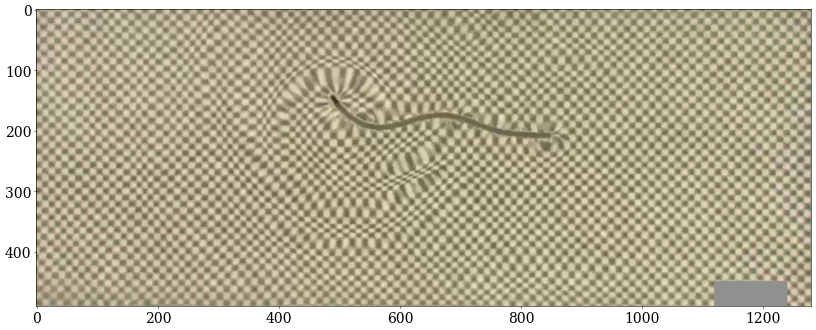

In [6]:
im = skimage.io.imread(f'capture-P1-2V-9Hz-color.tiff')
plt.imshow(im)
im_copy = im.copy()

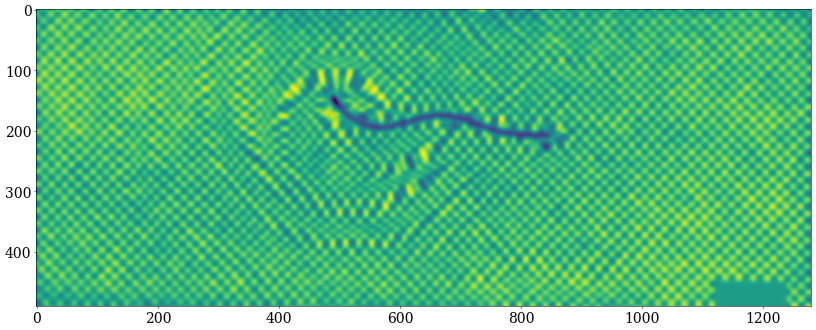

In [7]:
# ref_sobel = sobel(im)
ref_gray = gris(im)

ref_gaussian = gaussian(ref_gray, 4)

plt.figure()
plt.imshow(ref_gaussian)
# plt.colorbar()


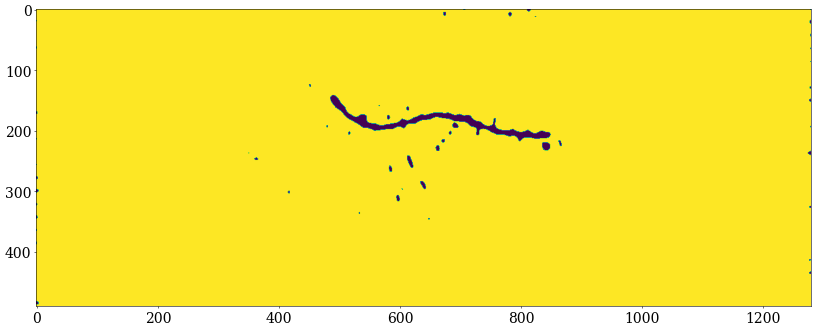

In [8]:
ref_binary = binarize(ref_gaussian, th=0.5)

plt.figure()
plt.imshow(ref_binary)

y, x = np.where(ref_binary!=0)
# y_sk, x_sk = np.where(ref_DSE!=0)
# im_copy[y,x] = [0, 255, 0]
# plt.imshow(im_copy)

In [3]:
from skimage.measure import label, regionprops, regionprops_table

[622379.0, 3.0, 19.0, 1.0, 22.0, 28.0, 2.0, 10.0, 1.0, 4.0, 3.0, 2.0, 1.0, 9.0, 6.0, 3886.0, 11.0, 2.0, 21.0, 8.0, 25.0, 63.0, 6.0, 2.0, 18.0, 12.0, 2.0, 22.0, 28.0, 145.0, 45.0, 23.0, 1.0, 110.0, 17.0, 1.0, 38.0, 12.0, 68.0, 1.0, 18.0, 1.0, 10.0, 43.0, 6.0, 7.0, 4.0, 11.0, 4.0, 3.0, 4.0, 5.0, 9.0, 18.0]
3886.0
[622379.0, 3886.0]
3886.0


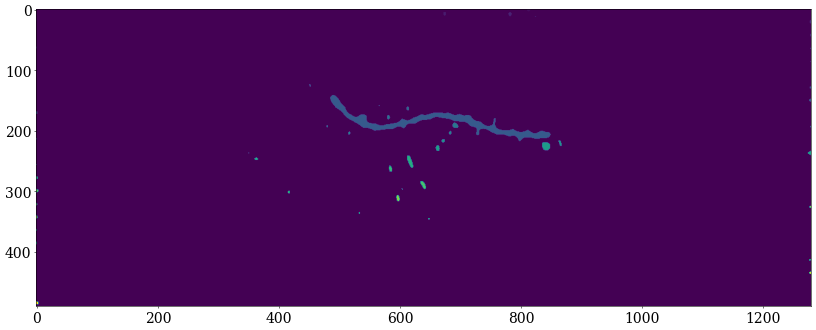

In [33]:
# ref_clear = binary_erosion(ref_binary)
# # ref_clear = binary_erosion(ref_clear)
# ref_clear_mask = 1-binary_opening(ref_clear)
# ref_clear = ref_clear_mask*255
# # ref_clear = cv.bitwise_not(ref_clear)

labeled_image = label(1-ref_binary, connectivity=1)
regions = regionprops(labeled_image)

object_features = skimage.measure.regionprops(labeled_image)
object_areas = [objf["area"] for objf in object_features]
print(object_areas)
print(object_areas[15])
n = [object_areas.index(x) for x in sorted(object_areas, reverse=True)[:2]][1]
plt.figure()
plt.imshow(labeled_image)
print(sorted(object_areas, reverse=True)[:2])
print(object_areas[n])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


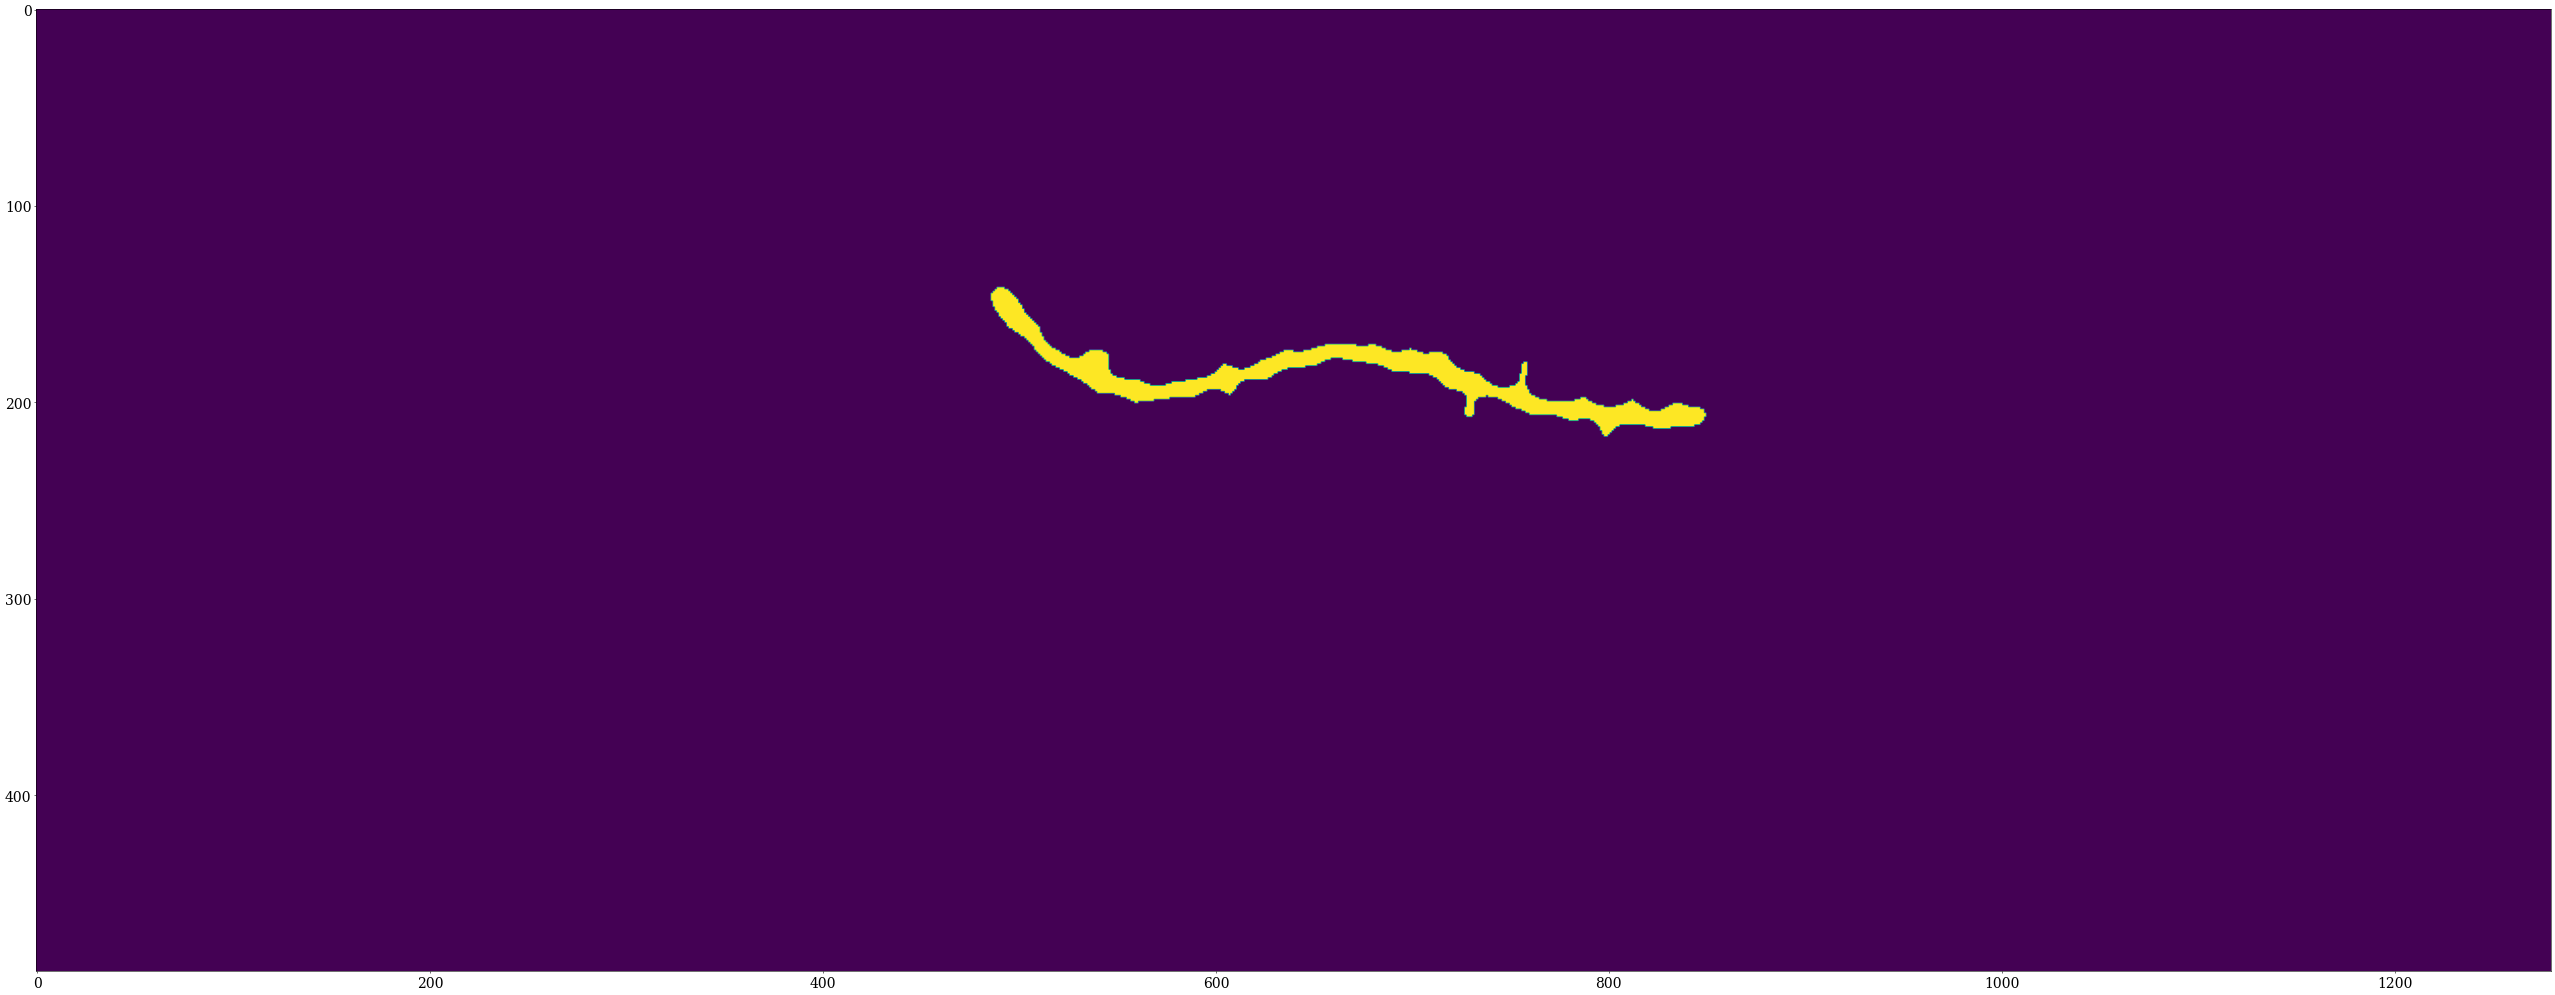

In [32]:
mask = np.zeros_like(labeled_image)
mask += (labeled_image==n+1).astype(int)
area  =  mask

print(area)
plt.figure(figsize=(300, 25))
plt.imshow(area)

# cv.imwrite('binary.tiff', area)

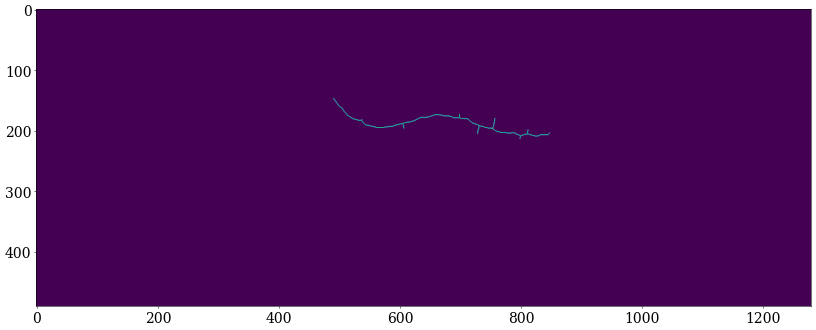

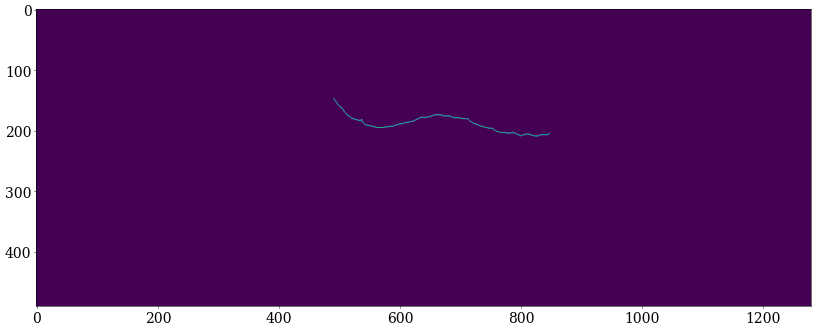

In [12]:
# ref_sk = skeletonize(area)
# plt.figure()
# plt.imshow(ref_sk)

ref_sk, dist = skimage.morphology.medial_axis(area, return_distance=True)
plt.figure()
plt.imshow(ref_sk)


ref_DSE = DSE_prune.skel_pruning_DSE(ref_sk, dist, 60)
plt.figure()
plt.imshow(ref_DSE)

In [14]:
from skimage.morphology import binary_dilation

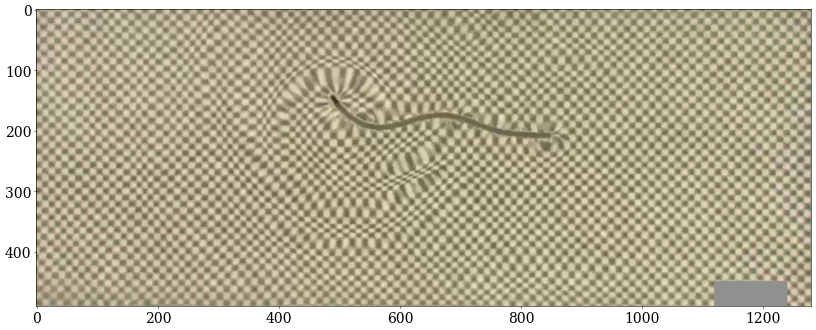

In [13]:
im = skimage.io.imread(f'capture-P1-2V-9Hz-color.tiff')
plt.imshow(im)
im_copy = im.copy()

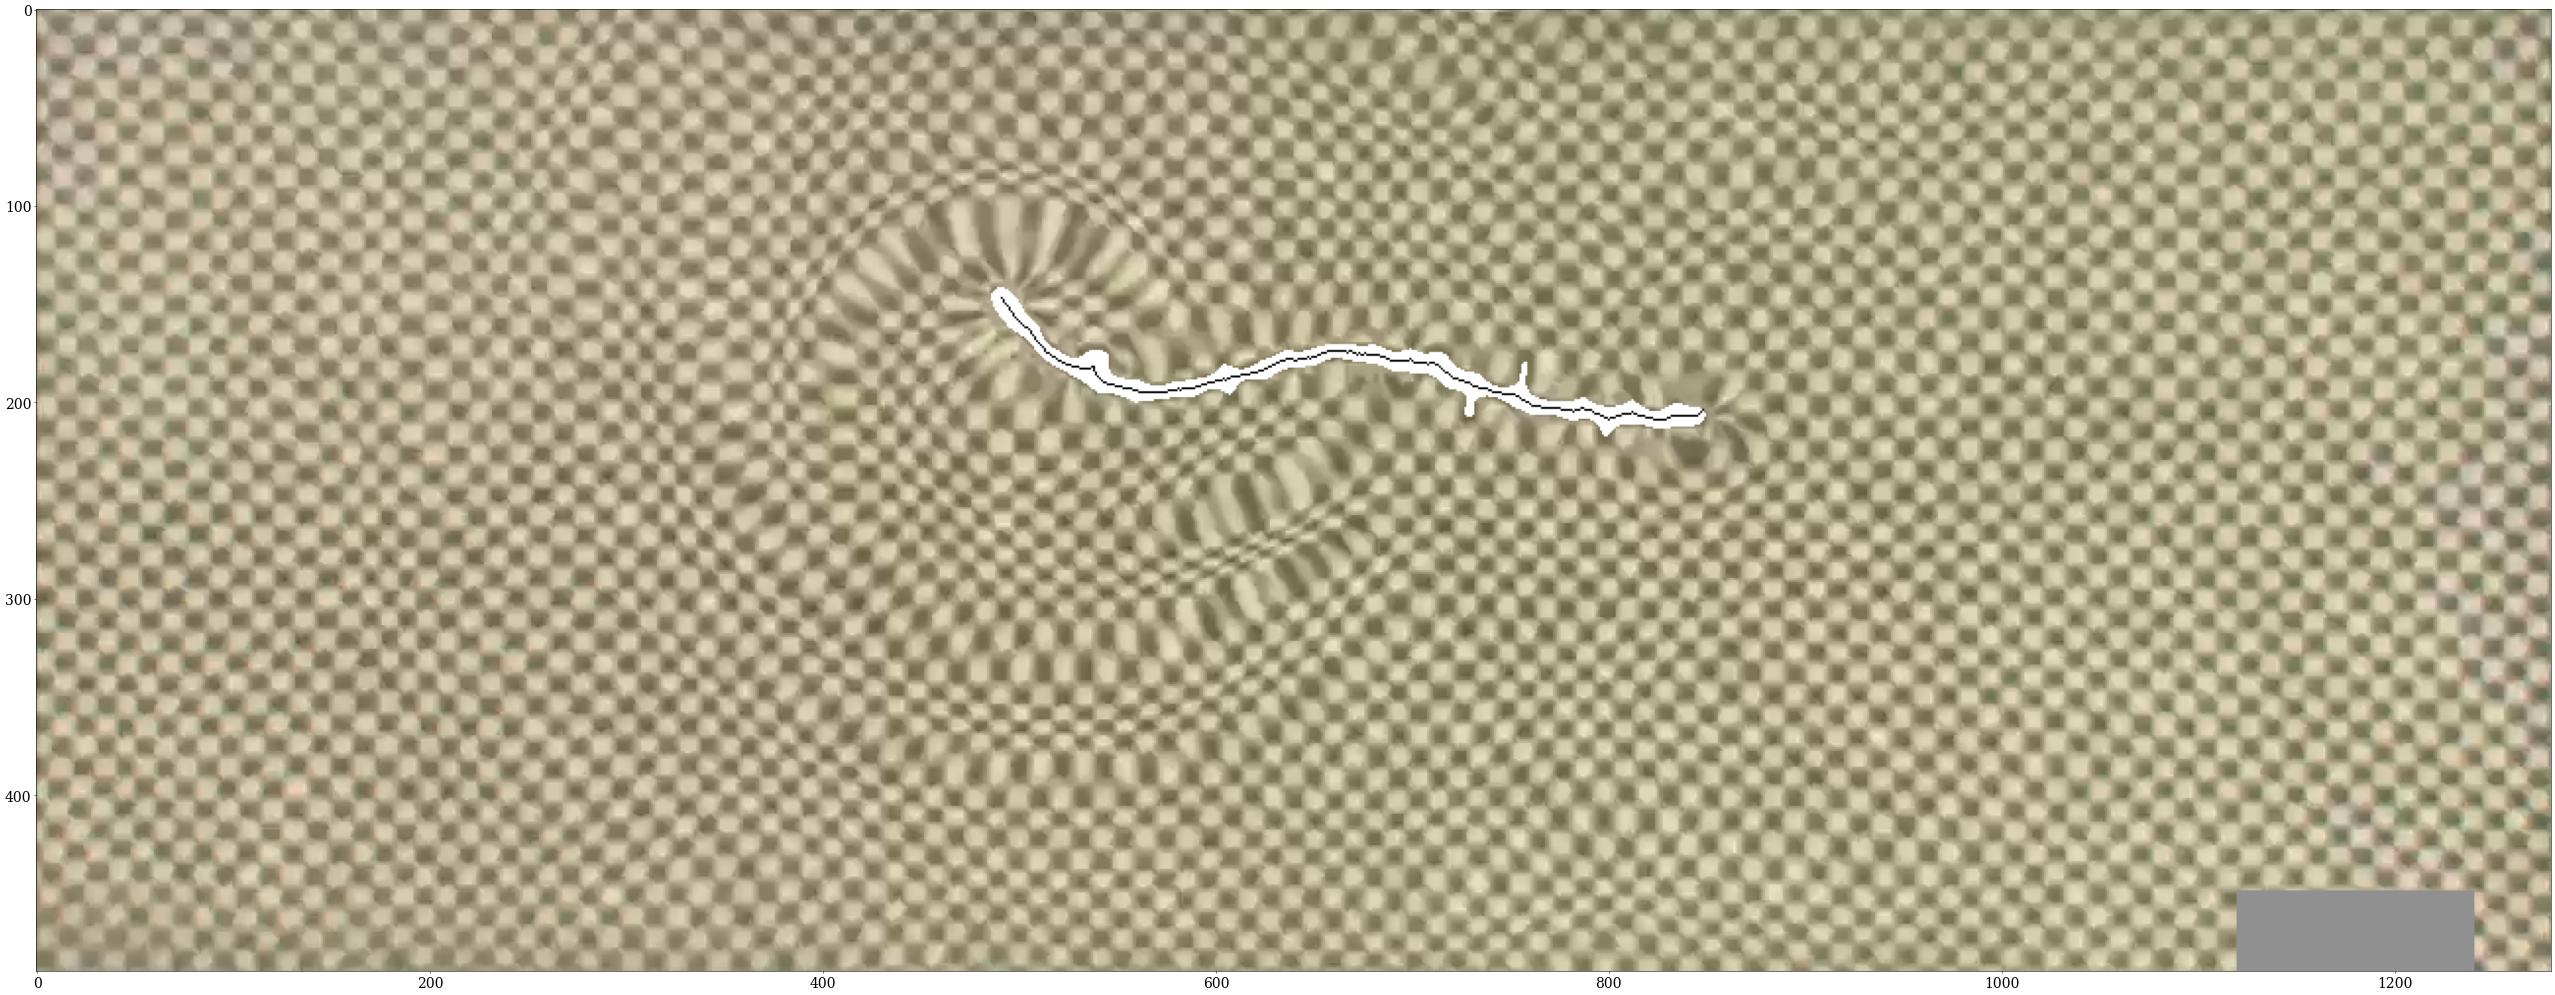

In [15]:
y, x = np.where(area!=0)
y_sk, x_sk = np.where(ref_DSE!=0)

line_th = skimage.morphology.thin(area)
y_t, x_t = np.where(line_th!=0) 
line_sk = skimage.morphology.skeletonize(area)
y_k, x_k = np.where(line_sk!=0)

im_copy[y, x] = [255,255,255]
im_copy[y_sk, x_sk] = 0
# im_copy[y_k, x_k] = [0,0,255]
# im_copy[y_t, x_t] = [255,0,0]
plt.figure(figsize=(300, 25))
plt.imshow(im_copy)

In [16]:
# import math
from scipy.ndimage import rotate
from PIL import Image 

In [17]:
def rotate_point(x, y, angle, center_point):
    """ Rotate a point around the origin by a given angle. """
    angle_rad = np.radians(angle)
    x -= center_point[0]
    y -= center_point[1]

    x_new = x * np.cos(angle_rad) - y * np.sin(angle_rad) + center_point[0]
    y_new = x * np.sin(angle_rad) + y * np.cos(angle_rad) + center_point[1]
    return x_new, y_new

def rotate_curve(x, y, angle, center_point):    
    # Rotate points
    x_rotated, y_rotated = [], []
    for xi, yi in zip(x, y):
        x_rot, y_rot = rotate_point(xi, yi, -angle, center_point)
        x_rotated.append(x_rot)
        y_rotated.append(y_rot)
    
    return np.array(x_rotated), np.array(y_rotated)

33


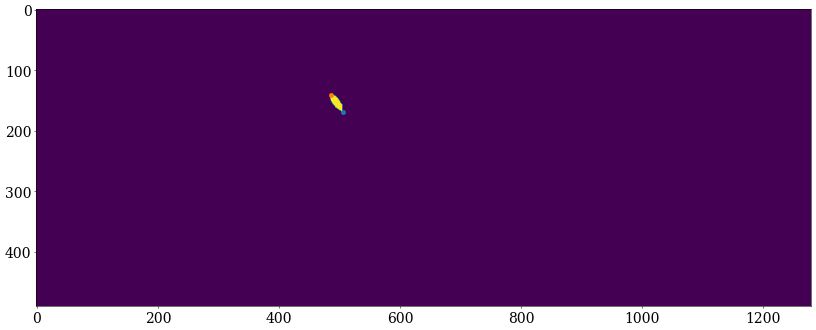

In [18]:
area = skimage.io.imread('binary.tiff')
# area = gaussian(area, 6)
# mask = area > np.max(area)*0.5
# canny = skimage.filters.sobel(area)
y, x = np.where(area!=0)
x_izq = np.min(x)
x_lim = x_izq+20
fondo = np.zeros_like(area)
fondo[:, 0:x_lim] = area[:, 0:x_lim]

sk = skimage.morphology.medial_axis(fondo)
y_sk, x_sk = np.where(sk!=0)
origin = np.array([x_sk[0], y_sk[0]])
point = np.array([x_sk[-1], y_sk[-1]])

plt.figure()
plt.imshow(fondo)
# plt.plot(origin[0], origin[1], 'o')
plt.plot(point[0], point[1], 'o')

dx, dy = point-origin
angle = np.degrees(np.arctan2(float(dy), float(dx)))
rot_angle = 0-angle

hip = int(np.sqrt(dx**2+dy**2))+7
delta_x = hip*np.cos(angle)
delta_y = hip*np.sin(angle)

punto_x = point[0] - delta_x
punto_y = point[1] - delta_y

plt.plot(punto_x, punto_y, 'o')

print(hip)

# angle = np.degrees(np.arctan2(float(dy), float(dx)))
# rot_angle = 0-angle

# Automatización

In [19]:
from skimage.morphology import remove_small_holes, binary_dilation, binary_closing, area_closing

In [165]:
def find(frame):
    y, x = np.where(frame!=0)
    x_head = np.min(x)
    
    filas = np.unique(y)
    y_head = int(np.mean(filas))
    return x, y, x_head, y_head

def tracker(vs, limites, SHOW=False):
        # Crea las listas vacias que van a ser nuestras mediciones
        pos_x = []
        pos_y = []
        # pos_x_sk = []
        # pos_y_sk = []
        
        frame_count = vs.get(7)
        tiempo = [f for f in range(1, int(frame_count))]
        i=0
        frames = []
        while(vs.isOpened()):
            ret, frame = vs.read()
            if ret:
                frame = cortar(frame, limites)
                frame_gray = gris(frame)
                frame_gaussian = gaussian(frame_gray, 4)
                frame_binary = 255 - binarize(frame_gaussian, th=0.5)
                # labeled_image, count= label(1-frame_binary, connectivity=1, return_num=True)
                # print(count)
                # object_features = skimage.measure.regionprops(labeled_image)
                # object_areas = [objf["area"] for objf in object_features]
                # n = [object_areas.index(x) for x in sorted(object_areas, reverse=True)[:2]][1]
                # mask = np.zeros_like(labeled_image)
                # mask += (labeled_image==n+1).astype(int)
                # area  =  255 * mask
                area = frame_binary
                
                im_izq = area[:, 0:1]
                sum_izq = np.sum(im_izq)

                # if object_areas[n] > 200 and sum_izq == 0:
                #     frames.append(i)
                #     # sk, dist = skimage.morphology.medial_axis(area, return_distance=True)
                #     # sk_DSE = DSE_prune.skel_pruning_DSE(sk, dist, 50)
                #     # y_sk, x_sk = np.where(sk!=0)

                #     # x_skmin = np.min(x_sk)
                #     # y_skmin = int(np.mean(y_sk[np.where(x_sk==x_skmin)]))
                #     # origin = np.array([x_skmin, y_skmin])

                #     # pos_x_sk.append(origin[0])
                #     # pos_y_sk.append(origin[1])

                #     x, y, x_head, y_head = find(area)
                #     pos_x.append(x_head)
                #     pos_y.append(y_head)

                #     if SHOW:
                #         frame[y, x] = [0, 255, 0]
                #         # frame[y_sk, x_sk] = [255,0,0]
                #         # frame = cv.circle(frame, (int(origin[0]), int(origin[1])), radius=2, color=(0, 0, 255), thickness=-1)
                #         frame = cv.circle(frame, (int(x_head), int(y_head)), radius=2, color=(0, 0, 0), thickness=-1)
                #         cv.imshow('frame', frame)
                #     if cv.waitKey(1) & 0xFF == ord('q'):
                #         break
                # else:
                #      continue
                frames.append(i)
                # sk, dist = skimage.morphology.medial_axis(area, return_distance=True)
                # sk_DSE = DSE_prune.skel_pruning_DSE(sk, dist, 50)
                # y_sk, x_sk = np.where(sk!=0)

                 # x_skmin = np.min(x_sk)
                 # y_skmin = int(np.mean(y_sk[np.where(x_sk==x_skmin)]))
                 # origin = np.array([x_skmin, y_skmin])

                # pos_x_sk.append(origin[0])
                # pos_y_sk.append(origin[1])

                x, y, x_head, y_head = find(area)
                pos_x.append(x_head)
                pos_y.append(y_head)

                if SHOW:
                    frame[y, x] = [0, 255, 0]
                    # frame[y_sk, x_sk] = [255,0,0]
                    # frame = cv.circle(frame, (int(origin[0]), int(origin[1])), radius=2, color=(0, 0, 255), thickness=-1)
                    frame = cv.circle(frame, (int(x_head), int(y_head)), radius=2, color=(0, 0, 0), thickness=-1)
                    cv.imshow('frame', frame)
                if cv.waitKey(1) & 0xFF == ord('q'):
                        break
                i+=1
            else:
                    break
        cv.destroyAllWindows()
        vs.release()
        return np.array(tiempo), np.array(pos_x), np.array(pos_y), frames #, np.array(pos_x_sk), np.array(pos_y_sk)

In [166]:
FILENAME='P1-2V-9Hz-cut (2)'
vs = cv.VideoCapture('videos\\FCD\\P1\\telgopor\\P1-4V-5Hz-60mm.mp4')
lim = [0, 1280, 110, 600]
t,x,y,f = tracker(vs, lim, SHOW=True)

In [22]:
print(len(x), len(f))

288 288


In [23]:
import pandas as pd 

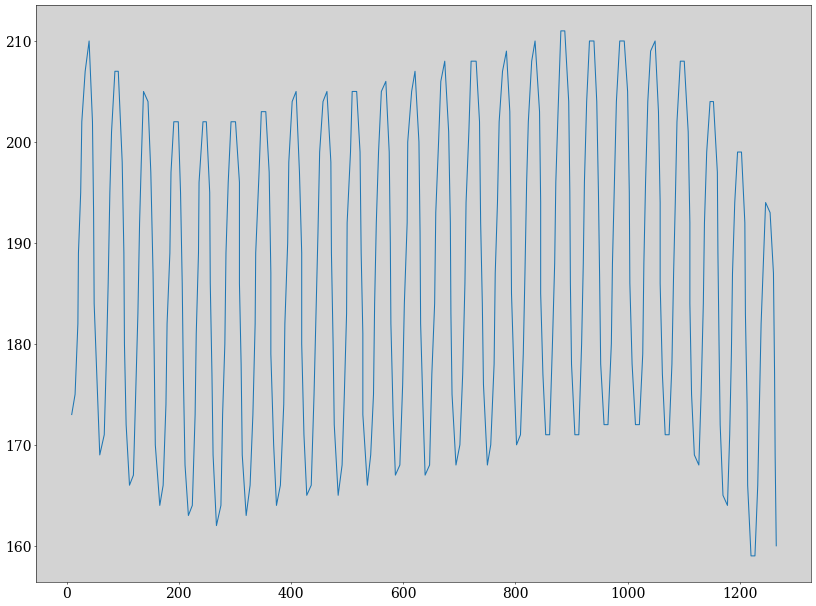

In [78]:
plt.plot(x, y)

In [5]:
import os
import pandas as pd

already_processed = [data.replace('.csv','') for data in os.listdir('datos\\60mm')]
# print(already_processed)

for filename in os.listdir('videos\\FCD\\P1\\telgopor'):
    video = cv.VideoCapture('videos\\FCD\\P1\\telgopor\\'+filename)
    lim = [0, 1280, 110, 600] #[xleft, xright, ytop, ydown]
    spl = filename[:-4].split('-')
    v,f = spl[1],spl[2]
    if f'{v}-{f}' not in already_processed:
        try:
            t,x,y,frame = tracker(video, lim, SHOW=False)
            # Guardo los datos
            if x.size>0 and y.size>0:
                pd.DataFrame().assign(t=t[:len(x)]).assign(x=x).assign(y=y).assign(frame=frame).to_csv(f'datos\\60mm\\{v}-{f}.csv')
                print(f'guardado: {filename}')
            else:
                print("No data ", filename)
        except:
            print(f'No se pudo, archivo: {filename}')
    print('siguiente')

guardado: P1-1V-10Hz-60mm.mp4
siguiente
guardado: P1-1V-15Hz-60mm.mp4
siguiente
guardado: P1-1V-5Hz-60mm.mp4
siguiente
guardado: P1-2V-10Hz-60mm.mp4
siguiente
guardado: P1-2V-15Hz-60mm.mp4
siguiente
guardado: P1-2V-5Hz-60mm.mp4
siguiente
guardado: P1-3V-10Hz-60mm.mp4
siguiente
guardado: P1-3V-5Hz-60mm.mp4
siguiente
No se pudo, archivo: P1-4V-5Hz-60mm.mp4
siguiente


In [93]:
from natsort import natsorted
from scipy.optimize import curve_fit
f_lineal = lambda x,a,b: a*x + b

In [61]:
#We prepare a dataframe of all our filenames and a dataframe of all our csv's
csv_names = natsorted([filepath for filepath in os.listdir('datos\\60mm') if '.csv' in filepath])
filenamelist = pd.DataFrame().assign(name = csv_names)
df = [pd.read_csv(f'datos\\60mm\\{f}') for f in filenamelist['name']]
print(df)

In [72]:
df_namelist = filenamelist[filenamelist['name'].str.contains('V')] #We get the filenames corresponding to the frequency chosen
filtered_namelist = df_namelist['name'] #We get the names of those files
print(filtered_namelist)

0     1V-5Hz.csv
1    1V-10Hz.csv
2    1V-15Hz.csv
3     2V-5Hz.csv
4    2V-10Hz.csv
5    2V-15Hz.csv
6     3V-5Hz.csv
7    3V-10Hz.csv
Name: name, dtype: object


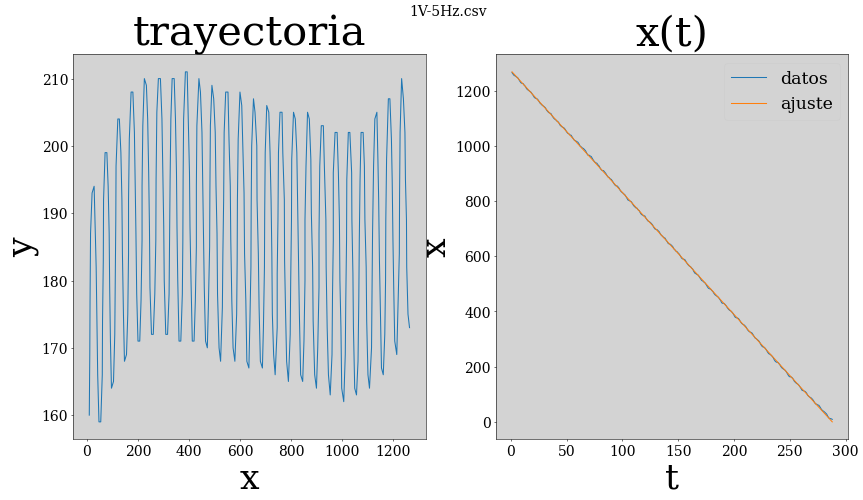

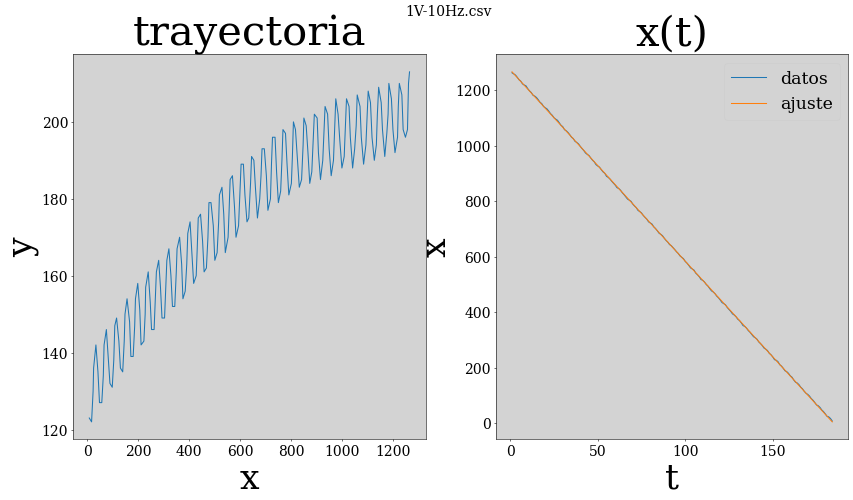

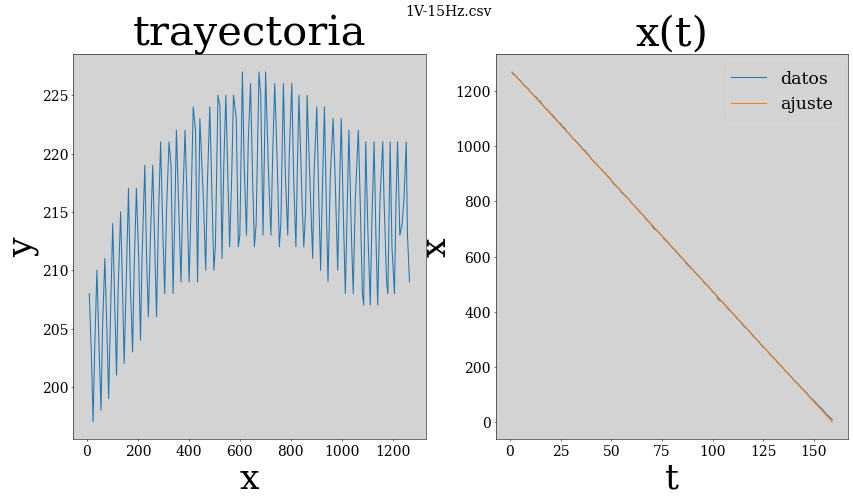

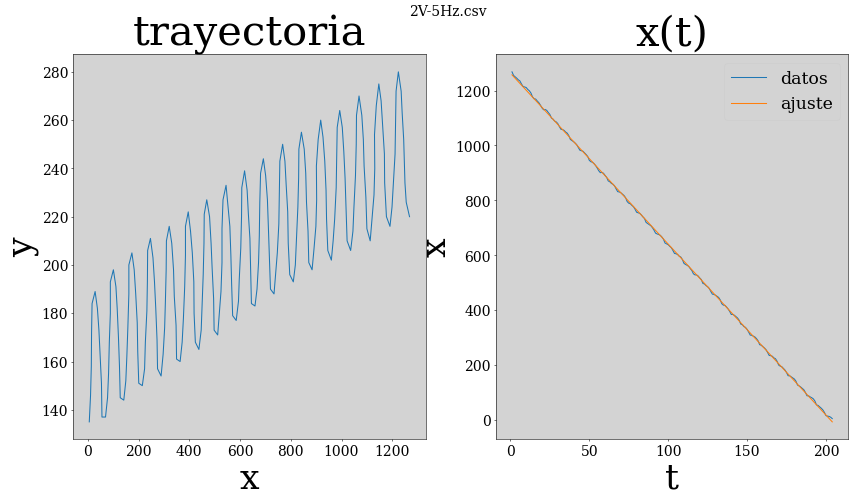

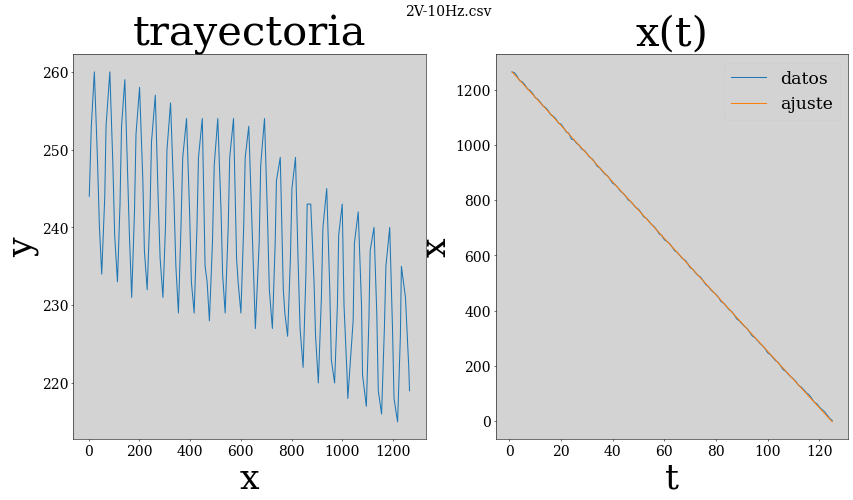

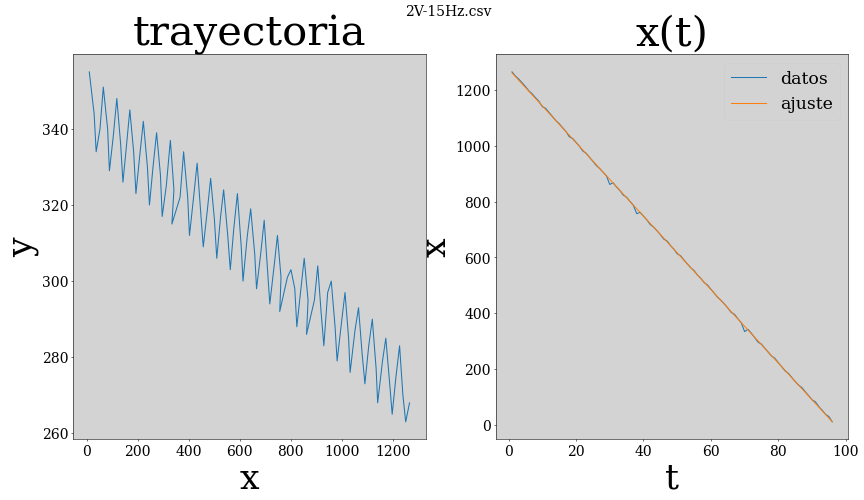

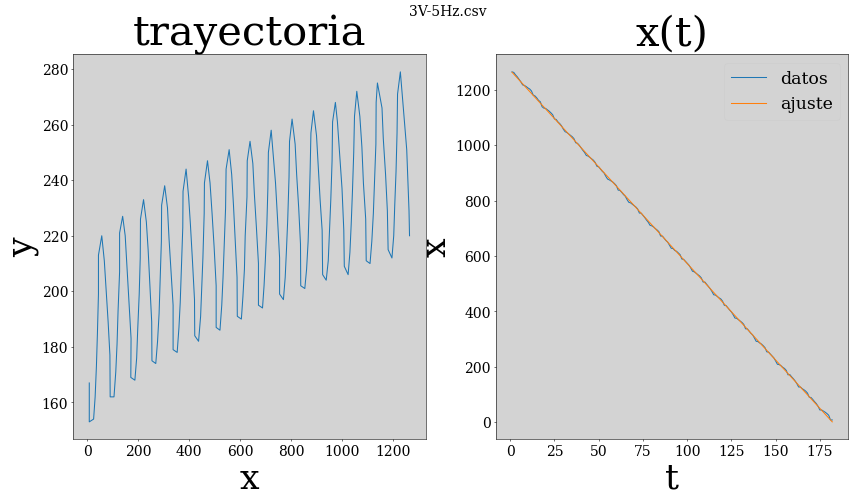

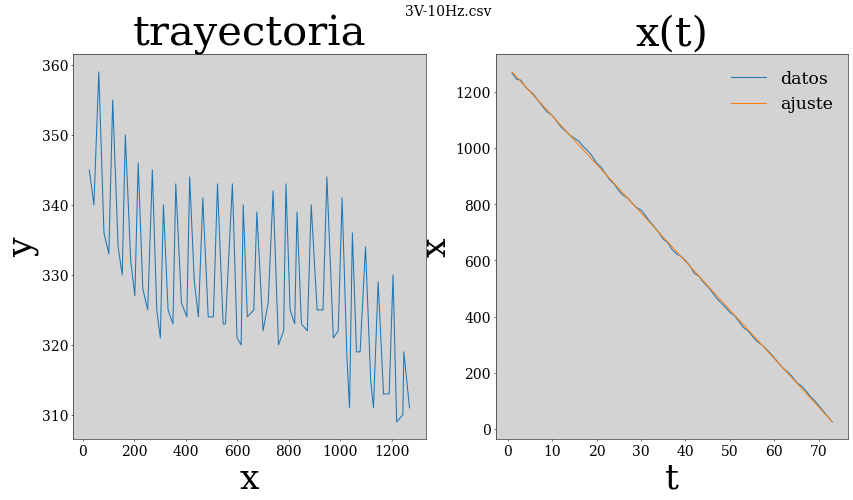

In [104]:
volt_list = []
frec_list = []
vel_list = []
vel_err_list = []
start_frame = []
end_frame = []

for i, filename in enumerate(filtered_namelist):
    
    df_txy = df[i] #We retrieve the dataframe corresponding to our current filename
    #We retrieve the metadata of our measurements from the filename

    s = filename.split('.')[0].split('-')
    v,f = s[0],s[1]
    vval = (float(v.split('V')[0].replace(',','.')))
    fval = float(f.split('Hz')[0].replace(',','.'))
    volt_list.append(vval)
    frec_list.append(fval)

    # #We retrieve the data from our dataframe
    t,x,y,frame = np.array(df_txy['t']), np.array(df_txy['x']), np.array(df_txy['y']), np.array(df_txy['frame'])
    frame = frame - 1
    start_frame.append(frame[0])
    end_frame.append(frame[-1])

    popt, popv = curve_fit(f_lineal, t, x)
    a, b = popt
    err_popt = np.sqrt(np.diag(popv))
    a_err, b_err = err_popt
    vel_list.append(a)
    vel_err_list.append(a_err)

    t_fit = np.linspace(t[0], t[-1], 1000)
    x_fit = f_lineal(t_fit, a, b)
    
    fig, [ax1, ax2] = plt.subplots(1,2, figsize = (20, 10))
    fig.suptitle(filename)
    ax1.plot(x, y)
    ax1.set_title('trayectoria')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    
    ax2.plot(t, x, label='datos')
    ax2.plot(t_fit, x_fit, label='ajuste')
    ax2.set_title('x(t)')
    ax2.set_xlabel('t')
    ax2.set_ylabel('x')
    ax2.legend()
    # popt, popv = curve_fit(f_lineal, t, x)
    # err_popt = np.sqrt(np.diag(popv))
    
    # volt_freq_map[popt[0]] = (vval,fval)

pd.DataFrame().assign(frec=frec_list).assign(volt=volt_list).assign(vel=vel_list).assign(vel_err=vel_err_list).assign(start_frame=start_frame).assign(end_frame=end_frame).to_csv(f'datos\\60mm\\velocidades.csv')
